# Super Resolution GAN (SRGAN) training

### Mount drive if in colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to repository
%cd /content/drive/MyDrive/Github/SRGAN

# !pip install albumentations==0.4.6

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/SRGAN


### Import needed modules

In [6]:
import config
import torch
from torch import nn
# Optimization algorithms
import torch.optim as optim
# Dataset manager
from torch.utils.data import DataLoader

from torchvision.models import vgg19

## 0. Define and prepare data

### Import HR images

In [8]:
from dataset import MyImageFolder

dataset = MyImageFolder(root_dir="datasets/training/UxLES/HR")
print(f"{len(dataset)} samples in dir {dataset.root_dir}")

1126 samples in dir datasets/training/UxLES/HR


## 1. Create model

### Initialize Generator and Discriminator

In [9]:
from model import Generator, Discriminator

gen = Generator(in_channels=3).to(config.DEVICE)
disc = Discriminator(in_channels=3).to(config.DEVICE)

## 2. Loss and optimizer

### Loss

In [10]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(config.DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(input)
        return self.loss(vgg_input_features, vgg_target_features)

bce = nn.BCEWithLogitsLoss()
vgg_loss_fun = VGGLoss()
mse = nn.MSELoss()

### Optimizers

In [11]:
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.9, 0.999))

## 3. Training

### Train discriminator and generator functions

In [12]:
### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
def train_discriminator(D, opt, fake, high_res, bce):

    # Reset gradients to zero
    opt.zero_grad()

    # Train on real data
    pred_real = D(high_res)
    loss_real = bce(pred_real, torch.ones_like(pred_real) - 0.1 * torch.rand_like(pred_real))

    # Train on fake data
    pred_fake = D(fake.detach())
    loss_fake = bce(pred_fake, torch.zeros_like(pred_fake))

    loss = loss_real + loss_fake

    # Backward pass
    loss.backward()
    # Update weights
    opt.step()

    return loss

### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
def train_generator(D, opt, fake, high_res, vgg_loss, mse):

    # Reset gradients to zero
    opt.zero_grad()

    pred_fake = D(fake)

    adv_loss = 1e-3 * bce(pred_fake, torch.ones_like(pred_fake))
    vgg_loss = 0.006 * vgg_loss(fake, high_res)
    mse_loss = mse(fake, high_res)

    loss = adv_loss + vgg_loss + mse_loss

    # Backward pass
    loss.backward()
    # Update weights
    opt.step()

    return loss

### Load data

In [13]:
loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=config.NUM_WORKERS)

### Load last checkpoint

In [14]:
import os
from utils import load_checkpoint

checkpoint_dir = f'checkpoints/{config.TRAINING_SET}'

if config.LOAD_MODEL:
    load_checkpoint(
        os.path.join(checkpoint_dir, config.CHECKPOINT_GEN),
        gen,
        opt_gen,
        config.LEARNING_RATE
    )
    load_checkpoint(
        os.path.join(checkpoint_dir, config.CHECKPOINT_DISC), disc, opt_disc, config.LEARNING_RATE
    )

In [15]:
import utils
import importlib

importlib.reload(utils)

<module 'utils' from '/content/drive/MyDrive/Github/SRGAN/utils.py'>

### Training loop

SRGAN training: 

 Total training samples: 1126
 Number of epochs: 2
 Mini batch size: 16
 Number of batches: 71
 Learning rate: 0.0001



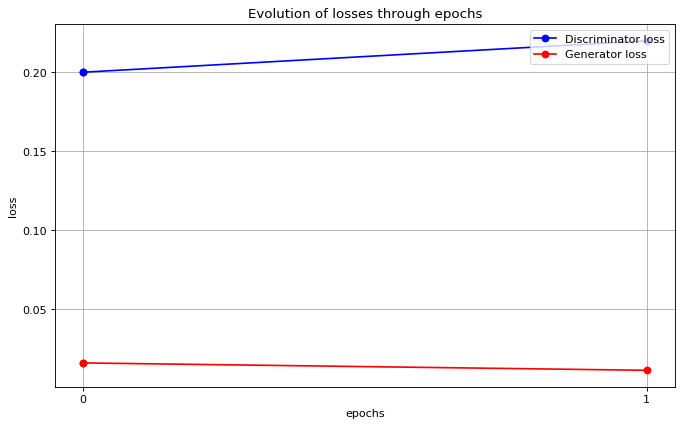

Epoch [1/2 - Loss D: 0.2199, Loss G: 0.0114]


In [21]:
from utils import plot_examples, save_checkpoint, plot_loss
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from IPython import display
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image



print(f"SRGAN training: \n")
print(f" Total training samples: {len(dataset)}\n Number of epochs: {config.NUM_EPOCHS}\n Mini batch size: {config.BATCH_SIZE}\n Number of batches: {len(loader)}\n Learning rate: {config.LEARNING_RATE}\n")


loss_disc = []
loss_gen = []

# Start the stopwatch
# t0 = process_time()

fig, ax = plt.subplots(figsize=(10,6), dpi= 80)

for epoch in range(config.NUM_EPOCHS):
    for idx, (low_res, high_res) in enumerate(loader):

        # Send images to device
        high_res = high_res.to(config.DEVICE)
        low_res = low_res.to(config.DEVICE)

        # Generate fake (high_res) image from low_res
        fake = gen(low_res)

        loss_disc_e = train_discriminator(disc, opt_disc, fake, high_res, bce)
        loss_gen_e = train_generator(disc, opt_gen, fake, high_res, vgg_loss_fun, mse)

        # At the end of every epoch
        if idx == config.BATCH_SIZE-1:


            # Append current epoch loss to list of losses
            loss_disc.append(float(loss_disc_e.detach().cpu()))
            loss_gen.append(float(loss_gen_e.detach().cpu()))

            # Plot loss
            x = np.arange(0, epoch+1)
            ax.plot(x, loss_disc, label='Discriminator loss', marker='o', color='b')
            ax.plot(x, loss_gen, label='Generator loss', marker='o', color='r')
            ax.set_title('Evolution of losses through epochs')
            ax.set(xlabel='epochs')
            ax.set(ylabel='loss')
            if epoch == 0:
              ax.legend(loc='upper right')
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            display.clear_output(wait=True)
            print(f"SRGAN training: \n")
            print(f" Total training samples: {len(dataset)}\n Number of epochs: {config.NUM_EPOCHS}\n Mini batch size: {config.BATCH_SIZE}\n Number of batches: {len(loader)}\n Learning rate: {config.LEARNING_RATE}\n")
            # Display current figure
            ax.grid()
            display.display(fig)
            # Pause execution 0.1s
            time.sleep(0.1)
            
            # Print progress every epoch
            print( 
                f"Epoch [{epoch}/{config.NUM_EPOCHS} - "
                f"Loss D: {loss_disc_e:.4f}, Loss G: {loss_gen_e:.4f}]"
                )
            plt.grid()
            fig.savefig("figures/metrics/loss_evol.png")
            plt.close()

    if config.SAVE_MODEL:
        save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=config.CHECKPOINT_DISC)

# Stop the stopwatch
# t1 = process_time()
# print(f"Elapsed time: {t1-t0}")
